# Conditional object generation using pre-trained models and plug-in networks
Prowadzący: **Patryk Wielopolski**, Politechnika Wrocławska

Abstrakt: Modele generatywne przyciągnęły uwagę wielu praktyków uczenia maszynowego w ostatnich latach, co zaowocowało modelami takimi jak StyleGAN do generowania ludzkiej twarzy lub PointFlow do generowania chmur punktów 3D. Jednak domyślnie nie możemy kontrolować jego procesu próbkowania, tj. nie możemy wygenerować próbki z określonym zestawem atrybutów. Obecne podejście polega na przekwalifikowaniu modelu z dodatkowymi danymi wejściowymi i inną architekturą, co wymaga czasu i zasobów obliczeniowych.

Podczas tego praktycznego warsztatu omówimy metodę, która pozwala nam generować obiekty o danym zestawie atrybutów bez ponownego uczenia modelu bazowego. W tym celu wykorzystamy modele normalizing flows – Conditional Masked Autoregressive Flow i Conditional Real NVP oraz sieci Plugin, w wyniku których powstaje Flow Plugin Network.


Cel warsztatów:
 * Praktyczne zapoznanie się z modelami Normalizing Flows oraz biblioteką nflows
 * Praktyczne zapoznanie się z metodą Flow Plugin Network

Agenda:
 * Wstęp do modeli generatywnych
 * Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**.
 * Metoda Flow Plugin Network (FPN)
 * Wykorzystanie metody FPN do warunkowego generowania obrazów
 * Wykorzystanie metody FPN do warunkowego generowania chmur punktów

## Wstęp do modeli generatywnych

## Modele generatywne

![](figures/three-generative-models.png)

## Normalizing Flows

![](figures/normalizing-flow.png)

# Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**

Omówienie modeli:
  * NICE
  * RealNVP
  * MAF

Omówienie warunkowych modeli:
  * Conditional NICE
  * Conditional RealNVP
  * Conditional MAF

### Konstrukcja biblioteki nflows

Krótkie omówienie biblioteki

  * Distributions - Bazowe rozkłady prawdopodobieństwa
  * Flows - Przykładowe implementacje modeli normalizing flows
  * Nn - Implementacje sieci neuronowych budujących bloki modelu
  * Transforms - Implementacje bloków transformujących w normalazing flows
  * Utils

### Toy example data

In [76]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

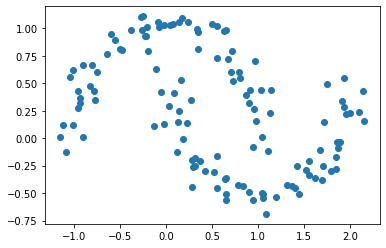

In [77]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

# NICE (Non-linear Independent Component Estimation)

#TODO: Opis. The NICE (Non-linear Independent Component Estimation; Dinh, et al. 2015) model is a predecessor of RealNVP. The transformation in NICE is the affine coupling layer without the scale term, known as additive coupling layer.

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})
\end{cases}
$$

In [78]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.nn import nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import AdditiveCouplingTransform
from nflows.transforms.normalization import BatchNorm


class NICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [79]:
nice = NICE(features=2, hidden_features=4, num_layers=1, num_blocks_per_layer=1)

In [80]:
# Sprawdźmy komponenty modelu
nice

NICE(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AdditiveCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=1, out_features=4, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (linear_layers): ModuleList(
                (0): Linear(in_features=4, out_features=4, bias=True)
                (1): Linear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=4, out_features=1, bias=True)
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)

In [81]:
nice = NICE(features=2, hidden_features=4, num_layers=4, num_blocks_per_layer=2)
nice_opt = optim.Adam(nice.parameters())

In [82]:
def train(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        opt.zero_grad()
        loss = -model.log_prob(inputs=x).mean()
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid = model.log_prob(xyinput).exp().reshape(100, 100)

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.title('iteration {}'.format(i + 1))
            plt.show()

In [ ]:
train(nice, nice_opt, num_iter=10000, iter_log=1000)

# Ćwiczenie (5 min.)

Modyfikując hiperparametry modelu wytrenuj model, który lepiej odwzoruje prawdziwy rozkład danych.

In [84]:
# TODO: Your code goes here.

### Badanie podstawowych funkcjonalności modeli
#### Samplowanie

In [85]:
x, y = datasets.make_moons(128, noise=.1)
x = torch.tensor(x, dtype=torch.float32)

In [86]:
samples = nice.sample(1000).detach().numpy()

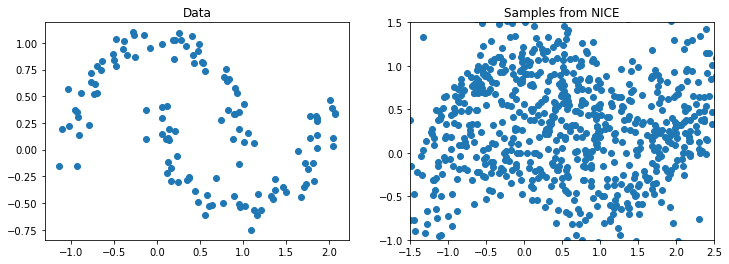

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(x[:, 0], x[:, 1])
ax[0].set_title('Data')

ax[1].scatter(samples[:, 0], samples[:, 1])
ax[1].set_title('Samples from NICE')

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

# RealNVP

#TODO: Opis

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d})})} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d})})}
\end{cases}
$$


# Ćwiczenie (5 min.)

Na podstawie powyższego kodu modelu NICE oraz biblioteki nflows zaimplementuj model RealNVP.

In [ ]:
# HINT: from nflows.transforms import ...


class RealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [89]:
real_nvp = RealNVP(features=2, hidden_features=4, num_layers=2, num_blocks_per_layer=2)
real_nvp_opt = optim.Adam(real_nvp.parameters())

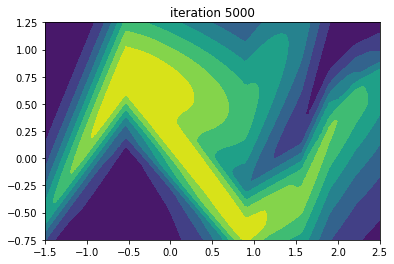

In [90]:
train(real_nvp, real_nvp_opt)

### Dalsze badanie podstawowych funkcjonalności modeli
#### Transformacje

In [91]:
prior_samples = real_nvp._distribution.sample(1000)

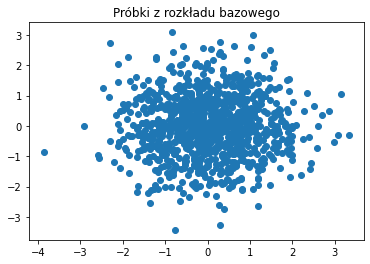

In [92]:
prior_samples_numpy = prior_samples.detach().numpy()

plt.scatter(prior_samples_numpy[:, 0], prior_samples_numpy[:, 1])
plt.title('Próbki z rozkładu bazowego')
plt.show()

In [93]:
nf_blocks = real_nvp._transform._transforms
nf_blocks

ModuleList(
  (0): AffineCouplingTransform(
    (transform_net): ResidualNet(
      (initial_layer): Linear(in_features=1, out_features=4, bias=True)
      (blocks): ModuleList(
        (0): ResidualBlock(
          (linear_layers): ModuleList(
            (0): Linear(in_features=4, out_features=4, bias=True)
            (1): Linear(in_features=4, out_features=4, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): ResidualBlock(
          (linear_layers): ModuleList(
            (0): Linear(in_features=4, out_features=4, bias=True)
            (1): Linear(in_features=4, out_features=4, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (final_layer): Linear(in_features=4, out_features=2, bias=True)
    )
  )
  (1): AffineCouplingTransform(
    (transform_net): ResidualNet(
      (initial_layer): Linear(in_features=1, out_features=4, bias=True)
      (blocks): ModuleList(
        (0): ResidualBlo

In [94]:
for transform in nf_blocks:
    print(transform)

AffineCouplingTransform(
  (transform_net): ResidualNet(
    (initial_layer): Linear(in_features=1, out_features=4, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layer): Linear(in_features=4, out_features=2, bias=True)
  )
)
AffineCouplingTransform(
  (transform_net): ResidualNet(
    (initial_layer): Linear(in_features=1, out_features=4, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4

In [95]:
consequitive_samples = [prior_samples]
current_sample = prior_samples

for transform in nf_blocks:
    current_sample, _ = transform(current_sample)
    consequitive_samples.append(current_sample)

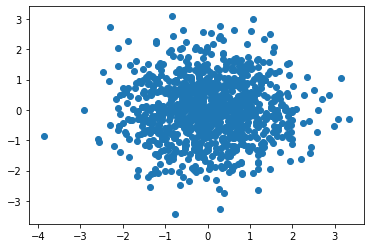

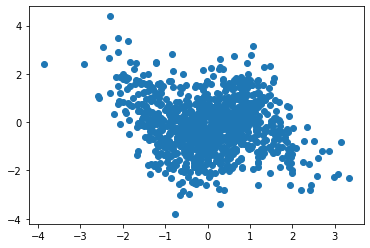

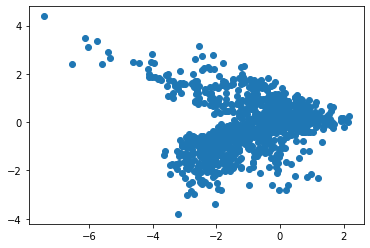

In [96]:
for s in consequitive_samples:
    s = s.detach().numpy()
    plt.scatter(s[:, 0], s[:, 1])
    plt.show()

# Masked Autoregressive Flow (MAF)

#TODO: Opis

$$p(\mathbf{x}) = \Pi^{N}_{i=1} p(x_i|\mathbf{x}_{1:i-1}) \textit{,}$$
gdzie
$$p(x_i|\mathbf{x}_{1:i-1}) = \mathcal{N}(x_i|\mu_i, (\exp{(\alpha_i)})^2 \textit{,}$$
gdzie $\mu_i = f_{\mu_i}(\mathbf{x_{1:i-1}})$ i $\alpha_i = f_{\alpha_i}(\mathbf{x_{1:i-1}})$


Przykładowo: $p(x_1, x_2) = p(x_1)p(x_2|x_1)$, gdzie $p(x_1) = \mathcal{N}(x_1|0, 4)$ i $p(x_2|x1) = \mathcal{N}(x_2|x_1^2, 1)$.

In [110]:
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation


class MaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [117]:
maf = MaskedAutoregressiveFlow(features=2, hidden_features=16, num_layers=4)
maf_opt = optim.Adam(maf.parameters())

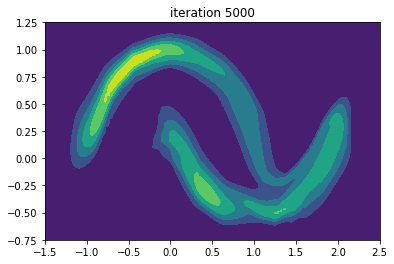

In [118]:
train(maf, maf_opt)

# Ćwiczenie (5 min.)

Zweryfikuj jak wyglądają kolejne transformacje modelu MAF analogicznie do przykładu RealNVP.

In [113]:
# TODO: Your code goes here.

# Przerwa (10 min.)

# Conditional NICE

#TODO: Opis

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})
\end{cases}
$$

In [119]:
class cNICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,  # New component
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,  # New component
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [123]:
c_nice = cNICE(features=2, hidden_features=8, num_layers=4, context_features=1)
c_nice_opt = optim.Adam(c_nice.parameters())

In [124]:
def train_conditional(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # New
        opt.zero_grad()
        loss = -model.log_prob(inputs=x, context=y).mean()  # New
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            fig, ax = plt.subplots(1, 2, figsize=(12, 8))
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid0 = model.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
                zgrid1 = model.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

            ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
            ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
            fig.suptitle('iteration {}'.format(i + 1))
            plt.show()

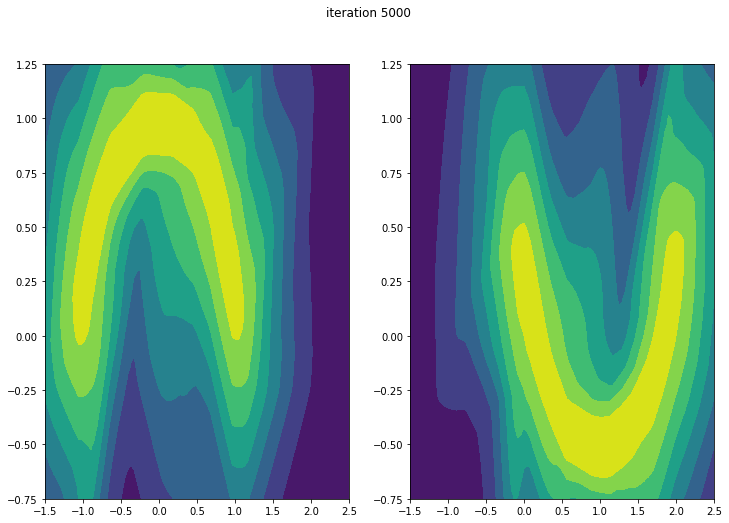

In [125]:
train_conditional(c_nice, c_nice_opt)

# Ćwiczenie

Wygeneruj próbki z modelu Conditional NICE dla górnego oraz dolnego półksiężyca

In [126]:
# TODO: Your code goes here.

# Conditional RealNVP

#TODO: Opis

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d}, \mathbf{c})})} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d}, \mathbf{c}))}}
\end{cases}
$$

In [104]:
from nflows.transforms import AffineCouplingTransform


class cRealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AffineCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [127]:
c_real_nvp = cRealNVP(features=2, hidden_features=4, context_features=1)
c_real_nvp_opt = optim.Adam(c_real_nvp.parameters())

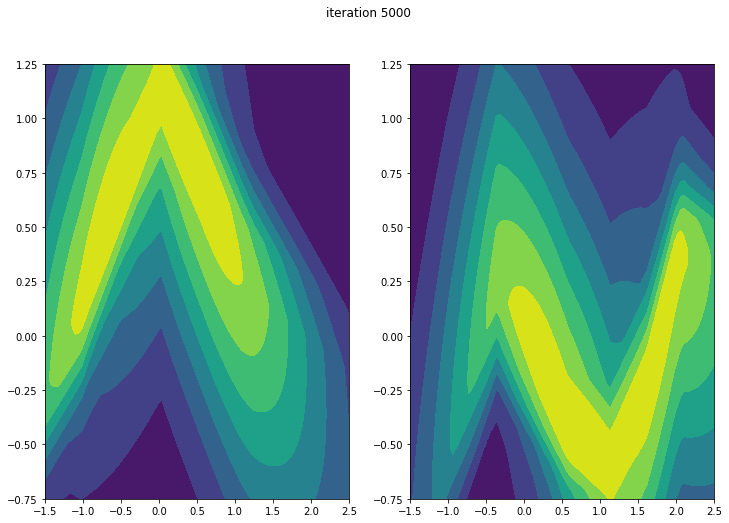

In [128]:
train_conditional(c_real_nvp, c_real_nvp_opt)

# Conditional Masked Autoregressive Flow (MAF)

#TODO: Opis

$$p(\mathbf{x} | \mathbf{c}) = \Pi^{N}_{i=1} p(x_i|\mathbf{x}_{1:i-1}, \mathbf{c}) \textit{,}$$
gdzie
$$p(x_i|\mathbf{x}_{1:i-1}, \mathbf{c}) = \mathcal{N}(x_i|\mu_i, (\exp{(\alpha_i)})^2 \textit{,}$$
gdzie $\mu_i = f_{\mu_i}(\mathbf{x_{1:i-1}}, \mathbf{c})$ i $\alpha_i = f_{\alpha_i}(\mathbf{x_{1:i-1}}, \mathbf{c})$


In [107]:
class cMaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [108]:
c_maf = cMaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
c_maf_opt = optim.Adam(c_maf.parameters())

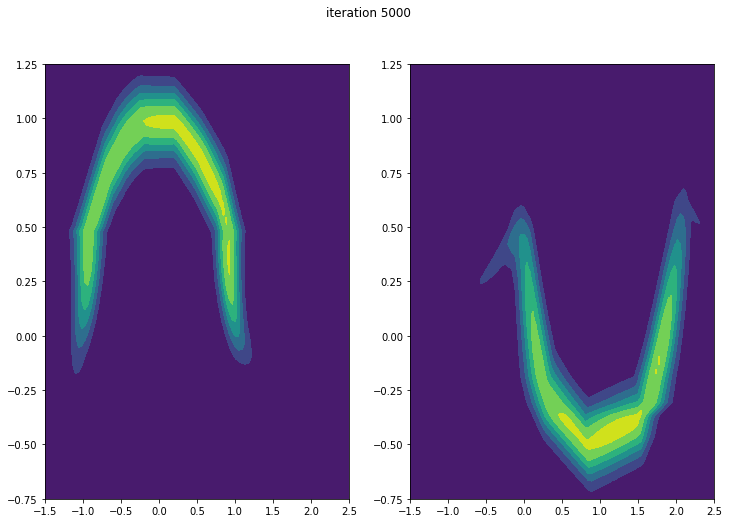

In [109]:
train_conditional(c_maf, c_maf_opt)

## Metoda Flow Plugin Network (FPN)

### Koncepcja Plugin Network

![Plugin Network](figures/plugin_koperski.png)

Pomysł:
 - Rozszerzenie istniejącej sieci neuronowej bez dodatkowego treningu, np. gdy pojawią się dane z dodatkową informację (eng. partial evidence)

Założenia koncepcji:
 - Nie przetrenowujemy oryginalnej sieci lecz jedynie trenujmy komponent plugin
 - Czas predykcji modelu jest jedynie nieznacznie większy

### Koncepcja Flow Plugin Network

![](figures/schema-general.png)

Pomysł:
 - Rozszerzenie Plugin Networku do modeli generatywnych

## Wykorzystanie metody FPN do warunkowego generowania obrazów

In [129]:
# Based on: https://github.com/lyeoni/pytorch-mnist-VAE

import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3, z_dim):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.e_fc1 = nn.Linear(x_dim, h_dim1)
        self.e_fc2 = nn.Linear(h_dim1, h_dim2)
        self.e_fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc_mu = nn.Linear(h_dim3, z_dim)
        self.fc_logvar = nn.Linear(h_dim3, z_dim)
        # decoder part
        self.d_fc1 = nn.Linear(z_dim, h_dim3)
        self.d_fc2 = nn.Linear(h_dim3, h_dim2)
        self.d_fc3 = nn.Linear(h_dim2, h_dim1)
        self.d_fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.e_fc1(x))
        h = F.relu(self.e_fc2(h))
        h = F.relu(self.e_fc3(h))
        return self.fc_mu(h), self.fc_logvar(h)  # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)  # return z sample

    def decoder(self, z):
        h = F.relu(self.d_fc1(z))
        h = F.relu(self.d_fc2(h))
        h = F.relu(self.d_fc3(h))
        return torch.sigmoid(self.d_fc4(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


In [130]:
from torchvision import datasets, transforms

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'


# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


def model_train(model, loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(loader.dataset),
                                                                           100. * batch_idx / len(loader),
                                                                           loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def model_sample(model, z_dim):
    with torch.no_grad():
        z = torch.randn(64, z_dim).to(DEVICE)
        return model.decoder(z).to(DEVICE)


In [ ]:
z_dim = 40
bs = 500
num_epochs = 100

train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, h_dim3=128, z_dim=z_dim).to(DEVICE)
optimizer = optim.Adam(vae.parameters())

for epoch in range(1, num_epochs + 1):
    model_train(vae, train_loader, optimizer, epoch)

sample = model_sample(vae, z_dim)

* Kod do wytrenowania prostego VAE
* Wygenerowanie losowych obiektów
* Kod do wytrenowania prostego FPNa
* Wygenerowanie pożądanych obiektów

### Inne metody

  * PluGeN
  * StyleFlow

#TODO: Dodać po obrazku z przykładem i krótki opis

## Wykorzystanie metody FPN do warunkowego generowania chmur punktów

 * Zadanie: Wytrenować na podstawie powyższego kodu model do generowania chmur punktów
 * TODO: Dostarczyć PointFlowa (?)

## Bibliografia

[Normalizing Flows]()
[Flow based deep generative models](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html#nice)
[NICE]()
[RealNVP]()
[MAF]()
[Flow Plugin Network]()
